In [2]:
# Import required libraries
import deepchem as dc
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,KFold

# Import metrics for model evaluation
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.feature_selection import VarianceThreshold

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [3]:
data = pd.read_csv('../../data/GABAA.csv',encoding='gb18030')

# Feature extraction & Data splitting

In [4]:
# Generate molecular fingerprints using ECFP
featurizer = dc.feat.CircularFingerprint(size=1024,radius=4)
features = featurizer.featurize(data['smiles'])
#dataset = dc.data.NumpyDataset(features,data['class'])

In [5]:
# Initialize the VarianceThreshold object with a threshold of 0.98
vt = VarianceThreshold(threshold = (.98 * (1 - .98)))

# Remove low-variance features
X_new = vt.fit_transform(features)
dataset = dc.data.NumpyDataset(X_new,data['class'])

In [6]:
# Split dataset into training and test sets
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=200)

# GridSearchCV

In [7]:
# Define scoring metrics for GridSearchCV
scoring = {
         'AUC':make_scorer(roc_auc_score, needs_proba=True),
          'ACC':make_scorer(accuracy_score),
           'PRE':make_scorer(precision_score),
           'REC':make_scorer(recall_score),
            
}

# Define hyperparameter grid for Gradient Boosting Classifier
param_grid = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
              'n_estimators':[30,50,100,150,200],
              'max_depth': [ 4, 6, 8,10,12]}


# Initialize Gradient Boosting Classifier
gbdt_classifier = GradientBoostingClassifier(random_state=142)

# Perform hyperparameter tuning using GridSearchCV
gs = GridSearchCV(
                   gbdt_classifier,
                   param_grid,
                 scoring = scoring,
                  cv = KFold(n_splits=5, shuffle=True, random_state=200),
                 n_jobs = -1,
               refit = 'AUC',
               return_train_score = True)

gs_fit = gs.fit(train_dataset.X, train_dataset.y.ravel())

In [8]:
val_AUC = gs.best_score_
val_ACC = gs.cv_results_['mean_test_ACC'][gs.best_index_]
val_PRE = gs.cv_results_['mean_test_PRE'][gs.best_index_]
val_REC = gs.cv_results_['mean_test_REC'][gs.best_index_]

# GridSearchCV_Result

In [9]:
print('Best parameters: ', gs.best_params_)
print('Best score (AUC): ', gs.best_score_)
print('ACC: ',gs.cv_results_['mean_test_ACC'][gs.best_index_])
print('PRE: ',gs.cv_results_['mean_test_PRE'][gs.best_index_])
print('REC: ',gs.cv_results_['mean_test_REC'][gs.best_index_])

Best parameters:  {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}
Best score (AUC):  0.9270100321833942
ACC:  0.8358974358974358
PRE:  0.8168045112781955
REC:  0.8550710355588403


In [10]:
gxb_model = gs_fit.best_estimator_
gxb_model

GradientBoostingClassifier(learning_rate=0.05, max_depth=6, n_estimators=200,
                           random_state=142)

# Evaluate model

In [11]:
y_test_pred_proba = gxb_model.predict_proba(test_dataset.X)
y_test_pred = gxb_model.predict(test_dataset.X)

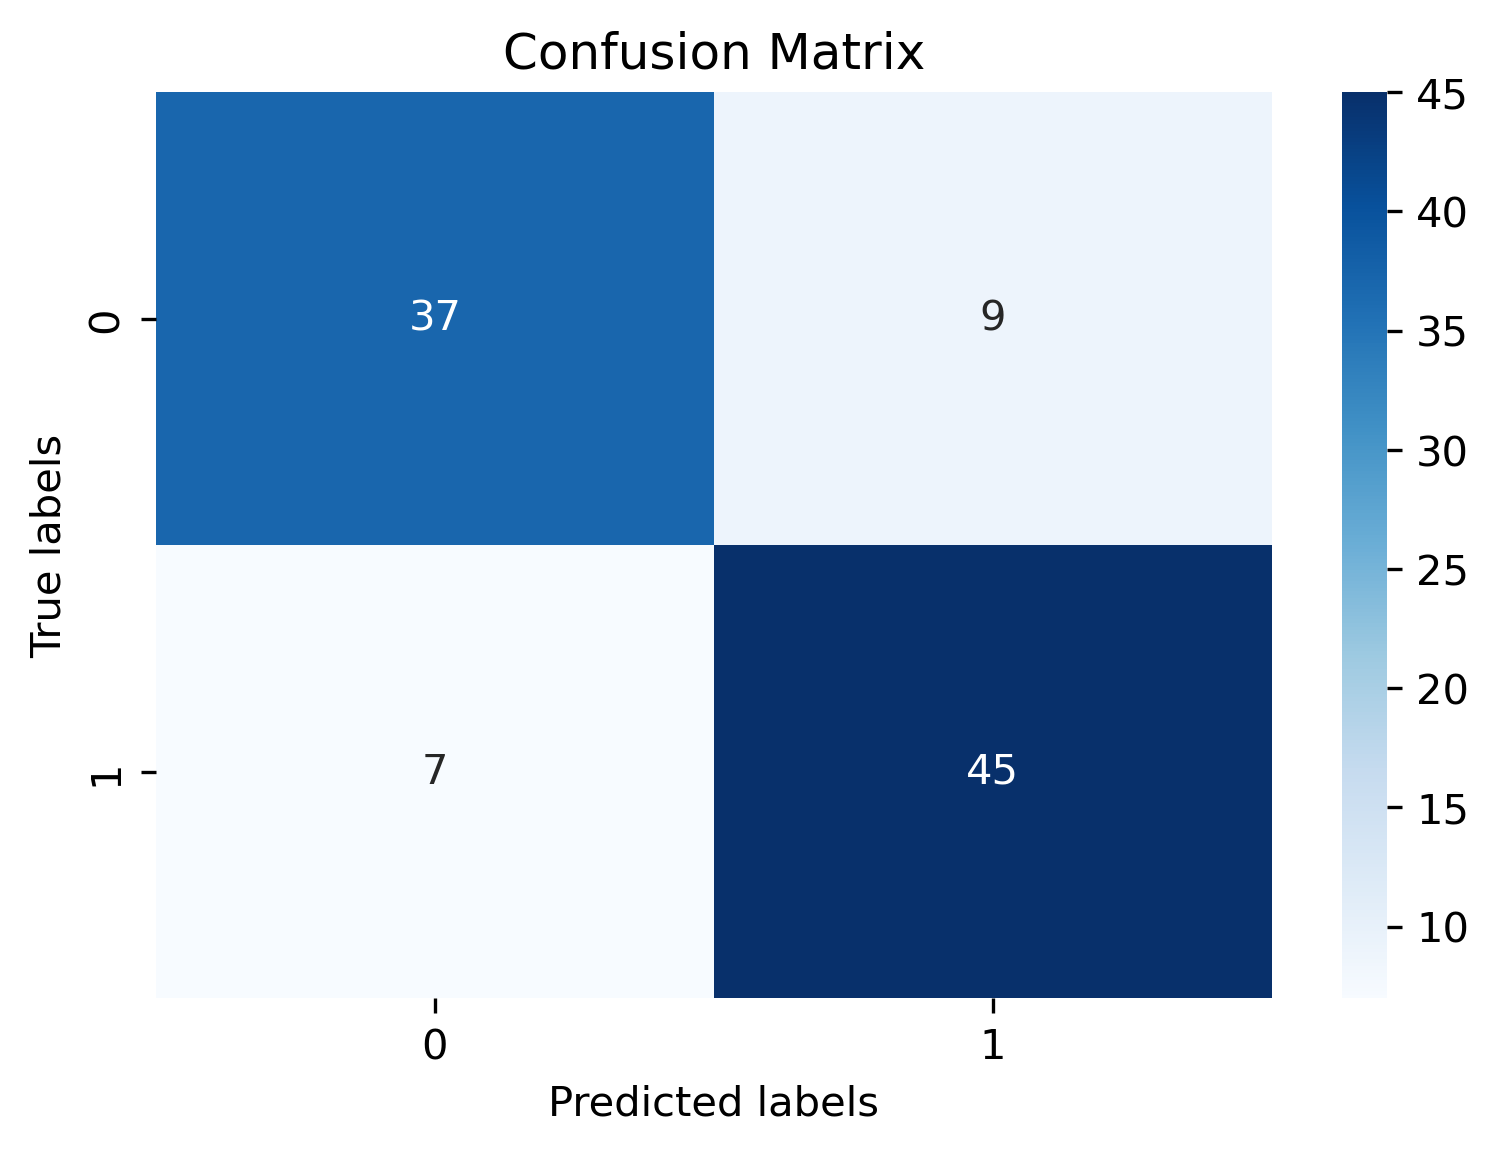

In [13]:
confusion_mat = confusion_matrix(test_dataset.y, y_test_pred)
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [14]:
test_pred_list = []
for test_score in y_test_pred_proba:
    test_score = test_score[1]
    test_pred_list.append(test_score)

In [15]:
test_pred_array = np.array(test_pred_list)

In [16]:
test_AUC = roc_auc_score(test_dataset.y,test_pred_list)
test_ACC = accuracy_score(test_dataset.y,np.round(test_pred_array))
test_PRE = precision_score(test_dataset.y,np.round(test_pred_array))
test_REC = recall_score(test_dataset.y,np.round(test_pred_array))

# model evaluation

In [17]:
performance_dataset = {
    'AUC':[val_AUC,test_AUC],
    'ACC':[val_ACC,test_ACC],
    'PRE':[val_PRE,test_PRE],
    'REC':[val_REC,test_REC]
}

In [18]:
performance = pd.DataFrame(performance_dataset,index=['val','test'])
performance

,AUC,ACC,PRE,REC
val,0.927010,0.835897,0.816805,0.855071
test,0.897575,0.836735,0.833333,0.865385
